In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Specify the data size

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

Generator Network

In [19]:
def generator(img_shape, z_dim):
    
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

Discriminator Network

In [20]:
def discriminator(img_shape):
    
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    # Hidden layer
    model.add(Dense(128))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)

In [21]:
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = generator(img_shape, z_dim)

# Generated image to be used as input
z = Input(shape=(100,))
img = generator(z)

# Keep Discriminator’s parameters constant during Generator training
discriminator.trainable = False

# The Discriminator’s prediction
prediction = discriminator(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

GAN Training function

In [22]:
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):
    
    # Load the dataset
    #path = "C:\\Users\\hgani\\Desktop\\CARLIFE DATA\\carlife_all_data\\Carlife_jpg"
    #X_train = cv2.imread(path + '\\'+ str(i) for i in os.listdir(path))
    (X_train, _), (_, _) = mnist.load_data()
    data_slice = 3000
    X_train = X_train[:data_slice,:]
    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            sample_images(iteration)

In [23]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise 
    gen_imgs = generator.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [24]:
import warnings; warnings.simplefilter('ignore')

GAN Training

0 [D loss: 0.002651, acc.: 100.00%] [G loss: 6.328685]
1000 [D loss: 0.020505, acc.: 100.00%] [G loss: 4.181127]
2000 [D loss: 0.077820, acc.: 96.88%] [G loss: 5.661728]
3000 [D loss: 0.197608, acc.: 92.97%] [G loss: 6.843472]
4000 [D loss: 0.136775, acc.: 94.92%] [G loss: 5.205476]
5000 [D loss: 0.461468, acc.: 78.52%] [G loss: 2.651729]
6000 [D loss: 0.119333, acc.: 95.31%] [G loss: 4.650574]
7000 [D loss: 0.349625, acc.: 84.77%] [G loss: 3.938936]
8000 [D loss: 0.478075, acc.: 80.47%] [G loss: 3.259602]
9000 [D loss: 0.324833, acc.: 86.33%] [G loss: 4.168482]
10000 [D loss: 0.217681, acc.: 91.80%] [G loss: 3.417312]
11000 [D loss: 0.411692, acc.: 83.20%] [G loss: 3.185366]
12000 [D loss: 0.282608, acc.: 87.11%] [G loss: 3.108163]
13000 [D loss: 0.283514, acc.: 86.72%] [G loss: 3.717927]
14000 [D loss: 0.341416, acc.: 84.77%] [G loss: 3.769761]
15000 [D loss: 0.382134, acc.: 81.64%] [G loss: 3.191629]
16000 [D loss: 0.329370, acc.: 85.94%] [G loss: 3.672557]
17000 [D loss: 0.251924, 

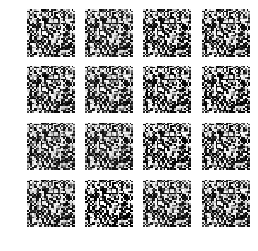

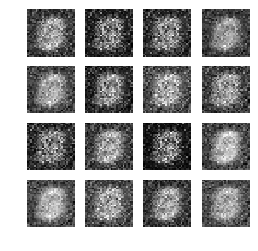

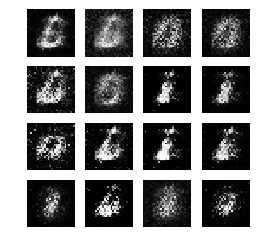

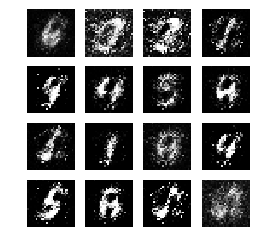

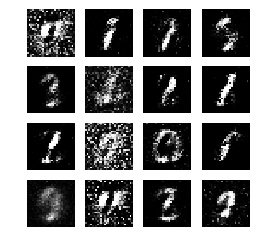

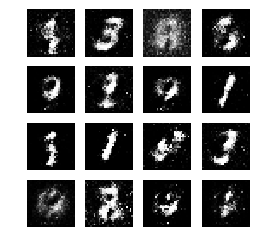

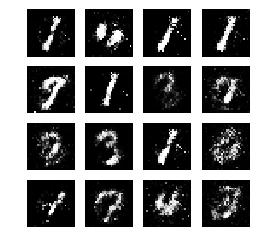

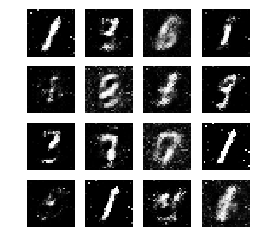

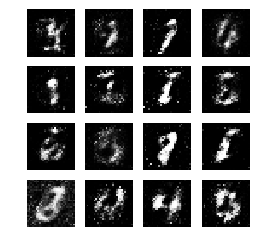

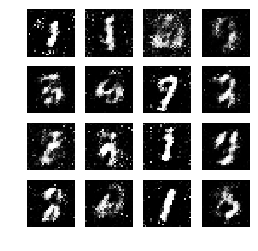

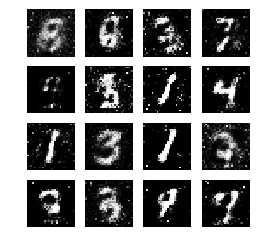

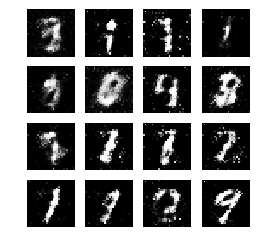

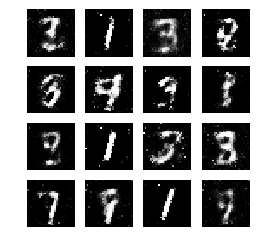

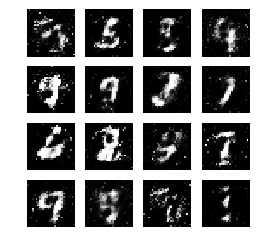

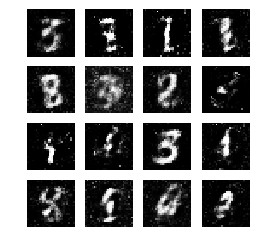

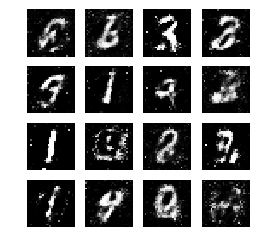

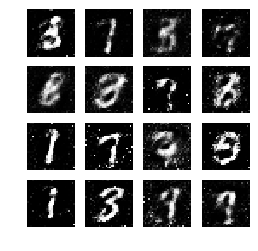

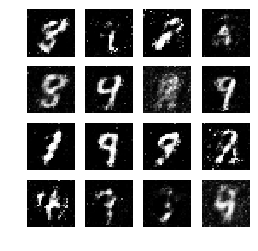

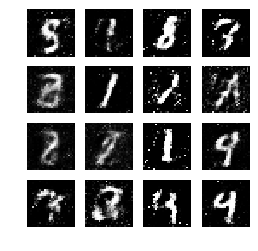

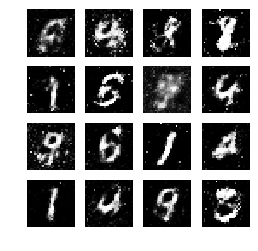

In [26]:
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)